<a href="https://colab.research.google.com/github/ilhamsofea/Machine-Unlearning-Big-Data-2024/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import umap
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define classes and the forget class
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
forget_class = 'ship'
forget_class_idx = classes.index(forget_class)

# Create retain and forget indices
train_retain_indices = [i for i, (_, label) in enumerate(trainset) if label != forget_class_idx]
train_forget_indices = [i for i, (_, label) in enumerate(trainset) if label == forget_class_idx]
test_retain_indices = [i for i, (_, label) in enumerate(testset) if label != forget_class_idx]
test_forget_indices = [i for i, (_, label) in enumerate(testset) if label == forget_class_idx]

# Create retain and forget sets
train_retain_set = Subset(trainset, train_retain_indices)
train_forget_set = Subset(trainset, train_forget_indices)
test_retain_set = Subset(testset, test_retain_indices)
test_forget_set = Subset(testset, test_forget_indices)

train_retain_loader = DataLoader(train_retain_set, batch_size=128, shuffle=True)
train_forget_loader = DataLoader(train_forget_set, batch_size=128, shuffle=False)
test_retain_loader = DataLoader(test_retain_set, batch_size=100, shuffle=False)
test_forget_loader = DataLoader(test_forget_set, batch_size=100, shuffle=False)
train_full_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_full_loader = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:05<00:00, 31156190.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define the ResNet18 model
def create_resnet18_model():
    model = models.resnet18(pretrained=False, num_classes=10)
    return model.to(device)

# Train the model
def train_model(model, loader, num_epochs=10, frozen_layers=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Freeze all layers except the final layer if frozen_layers is True
    if frozen_layers:
        for name, param in model.named_parameters():
            if not name.startswith('fc'):
                param.requires_grad = False

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(loader)}')

In [ ]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = np.zeros(10)
    total = np.zeros(10)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                label = labels[i]
                correct[label] += (preds[i] == label).item()
                total[label] += 1

    # Handle cases where total[label] might be zero
    accuracies = correct / (total + 1e-6)  # Adding a small epsilon to avoid division by zero

    return accuracies


In [ ]:
# Train on the full dataset
print("Training on the full CIFAR-10 dataset...")
full_model = create_resnet18_model()
train_model(full_model, train_full_loader)

# Evaluate the full model
print("Evaluating the full model...")
full_test_acc = evaluate_accuracy(full_model, test_full_loader)
print('Test Accuracy on the full CIFAR-10 dataset:', full_test_acc)

Training on the full CIFAR-10 dataset...
Epoch 1, Loss: 1.5408726686711811
Epoch 2, Loss: 1.1675392844335502
Epoch 3, Loss: 1.003381264484142
Epoch 4, Loss: 0.891103559023584
Epoch 5, Loss: 0.793290379330935
Epoch 6, Loss: 0.7025833348636432
Epoch 7, Loss: 0.6204752552006251
Epoch 8, Loss: 0.5488748524118873
Epoch 9, Loss: 0.4742978355082709
Epoch 10, Loss: 0.4207517277554173
Evaluating the full model...
Test Accuracy on the full CIFAR-10 dataset: [0.8   0.895 0.703 0.614 0.738 0.545 0.859 0.797 0.154 0.851]


1.1

In [ ]:
# Modify the ResNet18 to output intermediate representations
class IntermediateResNet18(nn.Module):
    def __init__(self):
        super(IntermediateResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=False, num_classes=10)
        self.features = nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            resnet18.relu,
            resnet18.maxpool,
            resnet18.layer1,
            resnet18.layer2,
            resnet18.layer3,
            resnet18.layer4,
            resnet18.avgpool
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

Extracting intermediate features from the test set...
Applying UMAP for dimensional reduction...
Visualizing UMAP results...


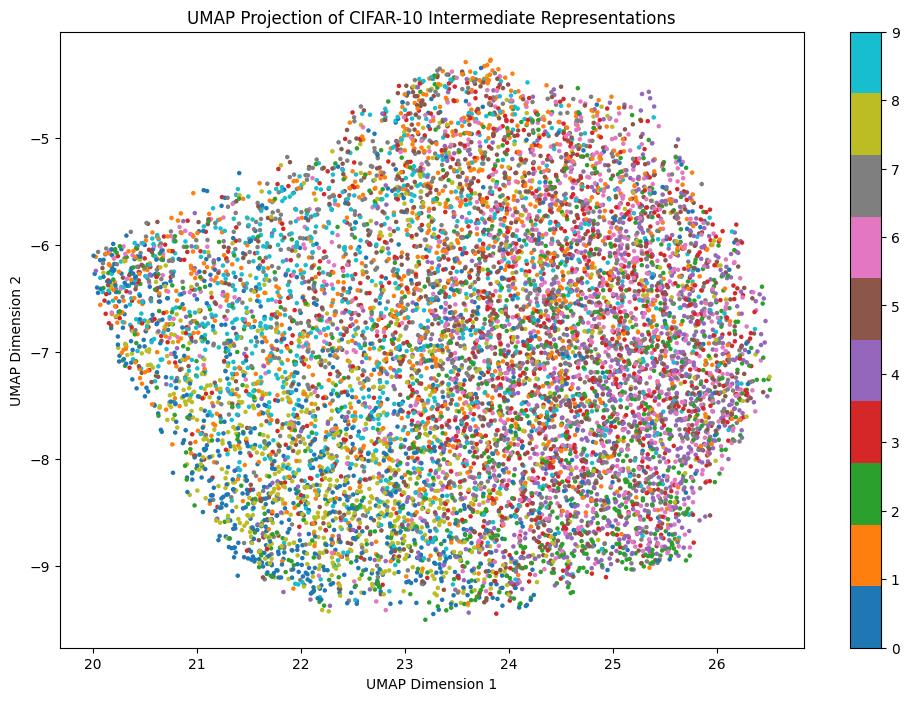

In [ ]:
# Extract intermediate features from the test set
print("Extracting intermediate features from the test set...")
intermediate_model = IntermediateResNet18().to(device)
intermediate_model.features.load_state_dict(full_model.state_dict(), strict=False)
features = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_full_loader:
        inputs = inputs.to(device)
        outputs = intermediate_model(inputs)
        features.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

features = np.concatenate(features)
labels_list = np.concatenate(labels_list)

# Apply UMAP for dimensional reduction
print("Applying UMAP for dimensional reduction...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_embedding = reducer.fit_transform(features)

# Visualize UMAP results
print("Visualizing UMAP results...")
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels_list, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of CIFAR-10 Intermediate Representations')
plt.show()

1.2

In [ ]:
# Train on the retain set (excluding 'ships')
print("Training on the retain set (excluding 'ships')...")
retain_model = create_resnet18_model()
train_model(retain_model, train_retain_loader)


Training on the retain set (excluding 'ships')...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 1.3367469393732874
Epoch 2, Loss: 0.9682525282895024
Epoch 3, Loss: 0.8055178838020022
Epoch 4, Loss: 0.6783896090293472
Epoch 5, Loss: 0.5712818278169091
Epoch 6, Loss: 0.4801593676886775
Epoch 7, Loss: 0.3965327998792583
Epoch 8, Loss: 0.31991639492017304
Epoch 9, Loss: 0.25771194588477636
Epoch 10, Loss: 0.20894140963950616


In [ ]:
# Evaluate on retain and forget sets
print("Evaluating the retain model...")
train_retain_acc = evaluate_accuracy(retain_model, train_retain_loader)
train_forget_acc = evaluate_accuracy(retain_model, train_forget_loader)
test_retain_acc = evaluate_accuracy(retain_model, test_retain_loader)
test_forget_acc = evaluate_accuracy(retain_model, test_forget_loader)

# Report accuracy for retain and forget sets
print("Reporting accuracy for all classes on different datasets...")
for i, class_name in enumerate(classes):
    print(f'Accuracy of {class_name} (Train Retain Set): {train_retain_acc[i] * 100:.2f}%')
    print(f'Accuracy of {class_name} (Train Forget Set): {train_forget_acc[i] * 100:.2f}%')
    print(f'Accuracy of {class_name} (Test Retain Set): {test_retain_acc[i] * 100:.2f}%')
    print(f'Accuracy of {class_name} (Test Forget Set): {test_forget_acc[i] * 100:.2f}%')

Evaluating the retain model...
Reporting accuracy for all classes on different datasets...
Accuracy of airplane (Train Retain Set): 99.20%
Accuracy of airplane (Train Forget Set): 68.62%
Accuracy of airplane (Test Retain Set): 91.90%
Accuracy of airplane (Test Forget Set): 0.00%
Accuracy of automobile (Train Retain Set): 90.28%
Accuracy of automobile (Train Forget Set): 8.21%
Accuracy of automobile (Test Retain Set): 76.80%
Accuracy of automobile (Test Forget Set): 0.00%
Accuracy of bird (Train Retain Set): 95.18%
Accuracy of bird (Train Forget Set): 2.54%
Accuracy of bird (Test Retain Set): 71.00%
Accuracy of bird (Test Forget Set): 0.00%
Accuracy of cat (Train Retain Set): 83.30%
Accuracy of cat (Train Forget Set): 2.97%
Accuracy of cat (Test Retain Set): 45.80%
Accuracy of cat (Test Forget Set): 0.00%
Accuracy of deer (Train Retain Set): 96.26%
Accuracy of deer (Train Forget Set): 4.38%
Accuracy of deer (Test Retain Set): 76.10%
Accuracy of deer (Test Forget Set): 0.00%
Accuracy of 

Q2

In [ ]:
# Apply Random Labels method to the forget set
print("Applying Random Labels method to the forget set...")
num_classes = 10
random_labels = np.random.randint(0, num_classes, size=len(train_forget_indices))

# Update the forget set with random labels
for i, idx in enumerate(train_forget_indices):
    trainset.targets[idx] = random_labels[i]

def evaluate_accuracy_random(model, loader, forget_class_idx):
    model.eval()
    correct = np.zeros(10)
    total = np.zeros(10)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                label = labels[i]
                prediction = preds[i]

                if label != forget_class_idx:
                    correct[label] += (prediction == label).item()
                    total[label] += 1

    accuracies = correct / (total + 1e-6)  # Adding epsilon to avoid division by zero

    return accuracies


Applying Random Labels method to the forget set...


In [ ]:
# Fine-tune the model with random labels for the forget set
print("Fine-tuning the model with random labels for the forget set...")
random_label_model = create_resnet18_model()

# Freeze all layers except the final layer
train_model(random_label_model, DataLoader(Subset(trainset, train_forget_indices), batch_size=128, shuffle=True), num_epochs=10, frozen_layers=True)

# Evaluate the fine-tuned model
print("Evaluating the fine-tuned model...")
train_retain_acc = evaluate_accuracy_random(random_label_model, train_retain_loader, forget_class_idx)
train_forget_acc = evaluate_accuracy_random(random_label_model, train_forget_loader, forget_class_idx)
test_retain_acc = evaluate_accuracy_random(random_label_model, test_retain_loader, forget_class_idx)
test_forget_acc = evaluate_accuracy_random(random_label_model, test_forget_loader, forget_class_idx)

# Report accuracy for retain and forget sets
print("Reporting accuracy after applying random labels...")
for i, class_name in enumerate(classes):
    print(f'Accuracy of {class_name} (Train Retain Set): {train_retain_acc[i] * 100:.2f}%')
    print(f'Accuracy of {class_name} (Train Forget Set): {train_forget_acc[i] * 100:.2f}%')
    print(f'Accuracy of {class_name} (Test Retain Set): {test_retain_acc[i] * 100:.2f}%')
    print(f'Accuracy of {class_name} (Test Forget Set): {test_forget_acc[i] * 100:.2f}%')


Fine-tuning the model with random labels for the forget set...
Epoch 1, Loss: 2.440644758939743
Epoch 2, Loss: 2.3462643325328827
Epoch 3, Loss: 2.2881158769130705
Epoch 4, Loss: 2.249161010980606
Epoch 5, Loss: 2.2112343430519106
Epoch 6, Loss: 2.2009707927703857
Epoch 7, Loss: 2.180108833312988
Epoch 8, Loss: 2.1608629703521727
Epoch 9, Loss: 2.143592357635498
Epoch 10, Loss: 2.132277727127075
Evaluating the fine-tuned model...
Reporting accuracy after applying random labels...
Accuracy of airplane (Train Retain Set): 23.64%
Accuracy of airplane (Train Forget Set): 47.31%
Accuracy of airplane (Test Retain Set): 26.00%
Accuracy of airplane (Test Forget Set): 0.00%
Accuracy of automobile (Train Retain Set): 4.28%
Accuracy of automobile (Train Forget Set): 19.06%
Accuracy of automobile (Test Retain Set): 3.30%
Accuracy of automobile (Test Forget Set): 0.00%
Accuracy of bird (Train Retain Set): 4.64%
Accuracy of bird (Train Forget Set): 14.80%
Accuracy of bird (Test Retain Set): 3.40%
Ac

q3

In [ ]:
import torch.nn.functional as F

def pgd_attack(model, inputs, labels, epsilon=0.03, alpha=0.01, num_iter=40):
    inputs = inputs.clone().detach().requires_grad_(True).to(device)
    labels = labels.to(device)
    original_inputs = inputs.clone().detach()

    for _ in range(num_iter):
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        perturbation = alpha * inputs.grad.sign()
        inputs = inputs + perturbation
        inputs = torch.clamp(inputs, 0, 1)
        inputs = torch.min(torch.max(inputs, original_inputs - epsilon), original_inputs + epsilon)
        inputs = inputs.detach().requires_grad_(True)

    return inputs.detach()


In [ ]:
# Fine-tune the model using adversarial samples
def fine_tune_with_adversarial_samples(model, loader, epsilon=0.03, alpha=0.01, num_iter=40, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            adv_inputs = pgd_attack(model, inputs, labels, epsilon, alpha, num_iter)

            optimizer.zero_grad()
            outputs = model(adv_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(loader)}')


In [ ]:
# Define the percentage of 'ships' images to use
percentages = [0.5, 1.0]
num_ships = len(train_forget_indices)
ships_indices_50 = train_forget_indices[:int(0.5 * num_ships)]
ships_indices_100 = train_forget_indices  # Full set

for percentage, indices in zip(percentages, [ships_indices_50, ships_indices_100]):
    print(f"Applying Boundary Shrink Method with {percentage*100}% of 'ships' images...")
    # Fine-tune the model with adversarial samples
    fine_tune_with_adversarial_samples(random_label_model, DataLoader(Subset(trainset, indices), batch_size=128, shuffle=True), epsilon=0.03, alpha=0.01, num_iter=40, num_epochs=10)

    # Evaluate the fine-tuned model
    print(f"Evaluating after using {percentage*100}% of 'ships' images...")
    train_retain_acc = evaluate_accuracy(random_label_model, train_retain_loader)
    train_forget_acc = evaluate_accuracy(random_label_model, train_forget_loader)
    test_retain_acc = evaluate_accuracy(random_label_model, test_retain_loader)
    test_forget_acc = evaluate_accuracy(random_label_model, test_forget_loader)

    # Report accuracy
    print(f"Reporting accuracy after applying boundary shrink with {percentage*100}% 'ships' images...")
    for i, class_name in enumerate(classes):
        print(f'Accuracy of {class_name} (Train Retain Set): {train_retain_acc[i] * 100:.2f}%')
        print(f'Accuracy of {class_name} (Train Forget Set): {train_forget_acc[i] * 100:.2f}%')
        print(f'Accuracy of {class_name} (Test Retain Set): {test_retain_acc[i] * 100:.2f}%')
        print(f'Accuracy of {class_name} (Test Forget Set): {test_forget_acc[i] * 100:.2f}%')


Applying Boundary Shrink Method with 50.0% of 'ships' images...
Epoch 1, Loss: 3.2797311663627626
Epoch 2, Loss: 3.0203171491622927
Epoch 3, Loss: 2.8483420848846435
Epoch 4, Loss: 2.7223135113716124
Epoch 5, Loss: 2.6289670705795287
Epoch 6, Loss: 2.559794235229492
Epoch 7, Loss: 2.4989659905433657
Epoch 8, Loss: 2.463116633892059
Epoch 9, Loss: 2.4261823296546936
Epoch 10, Loss: 2.3817599058151244
Evaluating after using 50.0% of 'ships' images...
Reporting accuracy after applying boundary shrink with 50.0% 'ships' images...
Accuracy of airplane (Train Retain Set): 0.00%
Accuracy of airplane (Train Forget Set): 0.00%
Accuracy of airplane (Test Retain Set): 0.00%
Accuracy of airplane (Test Forget Set): 0.00%
Accuracy of automobile (Train Retain Set): 0.16%
Accuracy of automobile (Train Forget Set): 0.82%
Accuracy of automobile (Test Retain Set): 0.20%
Accuracy of automobile (Test Forget Set): 0.00%
Accuracy of bird (Train Retain Set): 0.00%
Accuracy of bird (Train Forget Set): 0.00%
Ac

Applying UMAP for dimensional reduction...
Visualizing UMAP results...


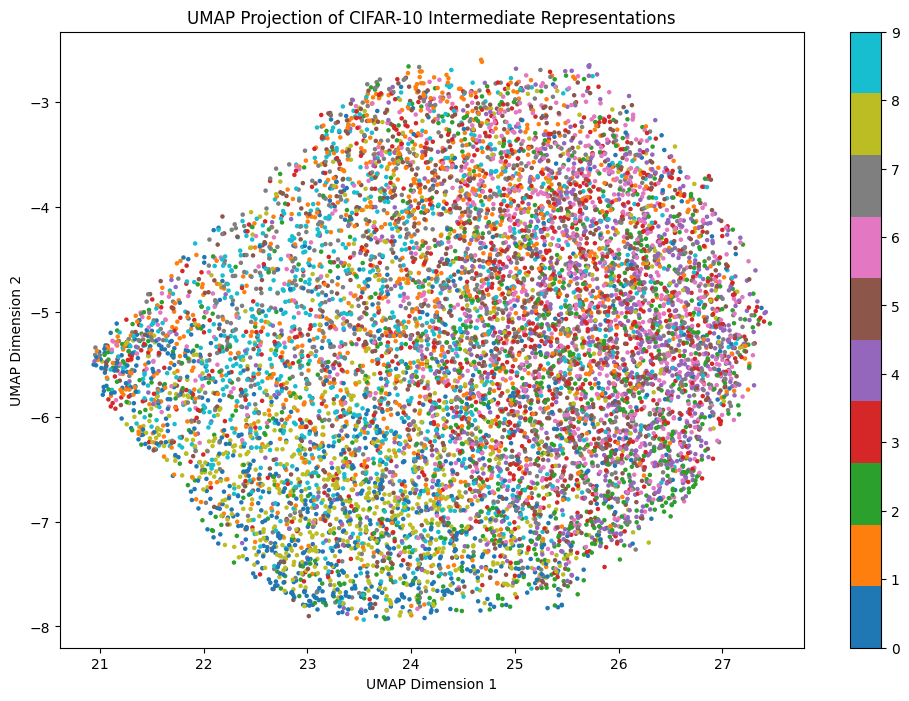

In [ ]:
# Apply UMAP for dimensional reduction
print("Applying UMAP for dimensional reduction...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_embedding = reducer.fit_transform(features)

# Visualize UMAP results
print("Visualizing UMAP results...")
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels_list, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of CIFAR-10 Intermediate Representations')
plt.show()


Q5

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


Extracting features from the test set...
Applying UMAP for dimensional reduction...
Visualizing UMAP results...


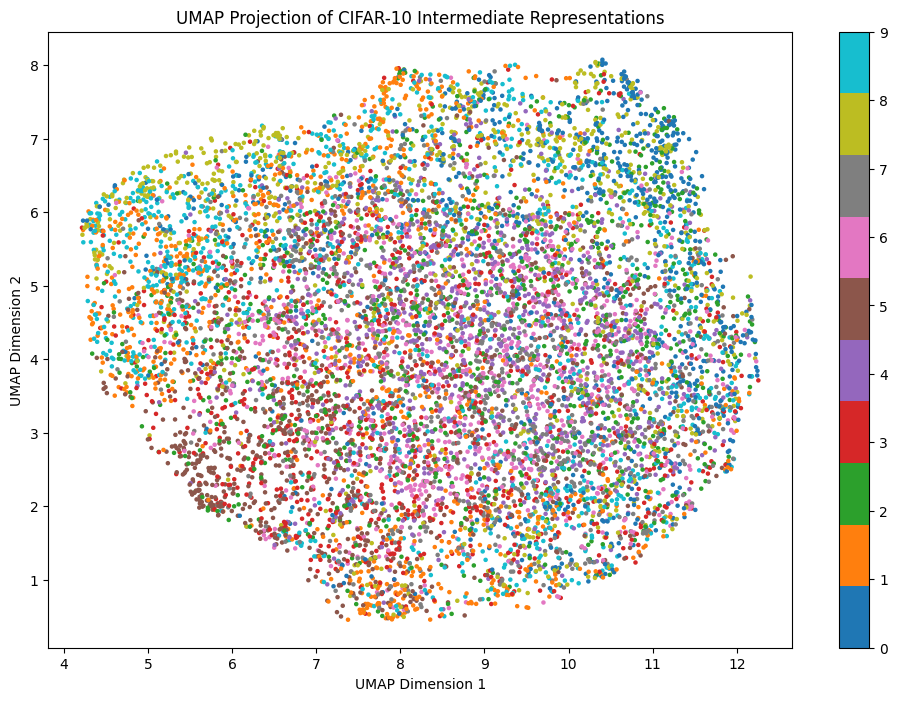

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import umap
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define classes and the forget class
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
forget_class = 'ship'
forget_class_idx = classes.index(forget_class)

# Create retain and forget indices
train_retain_indices = [i for i, (_, label) in enumerate(trainset) if label != forget_class_idx]
train_forget_indices = [i for i, (_, label) in enumerate(trainset) if label == forget_class_idx]
test_retain_indices = [i for i, (_, label) in enumerate(testset) if label != forget_class_idx]
test_forget_indices = [i for i, (_, label) in enumerate(testset) if label == forget_class_idx]

# Create retain and forget sets
train_retain_set = torch.utils.data.Subset(trainset, train_retain_indices)
train_forget_set = torch.utils.data.Subset(trainset, train_forget_indices)
test_retain_set = torch.utils.data.Subset(testset, test_retain_indices)
test_forget_set = torch.utils.data.Subset(testset, test_forget_indices)

# Load pretrained ResNet18 model
def load_resnet18():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    return model.to(device)

# Extract intermediate features
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())
    features = np.concatenate(features)
    labels_list = np.concatenate(labels_list)
    return features, labels_list

# Normalize features
def normalize_features(features):
    normalized_features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return normalized_features

# Apply UMAP for dimensional reduction
def apply_umap(features, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean')
    umap_embedding = reducer.fit_transform(features)
    return umap_embedding

# Visualize UMAP results
def visualize_umap(embedding, labels_list):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_list, cmap='tab10', s=5)
    plt.colorbar(scatter, ticks=range(len(classes)))
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Projection of CIFAR-10 Intermediate Representations')
    plt.show()

# Main function to orchestrate the process
def main():
    # Load model
    model = load_resnet18()

    # Create data loaders
    test_full_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    # Extract features from test set
    print("Extracting features from the test set...")
    features, labels_list = extract_features(model, test_full_loader)

    # Normalize features
    normalized_features = normalize_features(features)

    # Apply UMAP
    print("Applying UMAP for dimensional reduction...")
    umap_embedding = apply_umap(normalized_features)

    # Visualize UMAP results
    print("Visualizing UMAP results...")
    visualize_umap(umap_embedding, labels_list)

# Execute main function
if __name__ == "__main__":
    main()


Q6

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import umap
from torch.utils.data import DataLoader, Subset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
forget_classes = ['ship', 'airplane']
forget_class_indices = [classes.index(cls) for cls in forget_classes]

# Create retain and forget indices
train_retain_indices = [i for i, (_, label) in enumerate(trainset) if label not in forget_class_indices]
train_forget_indices = [i for i, (_, label) in enumerate(trainset) if label in forget_class_indices]
test_retain_indices = [i for i, (_, label) in enumerate(testset) if label not in forget_class_indices]
test_forget_indices = [i for i, (_, label) in enumerate(testset) if label in forget_class_indices]

# Create retain and forget sets
train_retain_set = Subset(trainset, train_retain_indices)
train_forget_set = Subset(trainset, train_forget_indices)
test_retain_set = Subset(testset, test_retain_indices)
test_forget_set = Subset(testset, test_forget_indices)

# Data loaders
train_retain_loader = DataLoader(train_retain_set, batch_size=128, shuffle=True)
train_forget_loader = DataLoader(train_forget_set, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

# Load pretrained ResNet18 model
def load_resnet18():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    return model.to(device)

model = load_resnet18()

# Apply random labels to forget set
def apply_random_labels(dataset, random_labels):
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, original_dataset, random_labels):
            self.original_dataset = original_dataset
            self.random_labels = random_labels

        def __len__(self):
            return len(self.original_dataset)

        def __getitem__(self, idx):
            img, _ = self.original_dataset[idx]
            random_label = self.random_labels[idx]
            return img, random_label

    return CustomDataset(dataset, random_labels)

# Apply random labels
num_forget_samples = len(train_forget_set)
random_labels = np.random.randint(0, len(classes), size=num_forget_samples)
random_label_forget_set = apply_random_labels(train_forget_set, random_labels)
random_label_loader = DataLoader(random_label_forget_set, batch_size=128, shuffle=True)

# Training function
def train(model, retain_loader, random_label_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()

        # Train on retain set
        for images, labels in retain_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Train on forget set with random labels
        for images, labels in random_label_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train(model, train_retain_loader, random_label_loader)

# Evaluate accuracy
def evaluate_accuracy(model, loader, forget_class_indices):
    model.eval()
    correct = np.zeros(len(classes))
    total = np.zeros(len(classes))

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                label = labels[i]
                prediction = preds[i]
                if label not in forget_class_indices:
                    correct[label] += (prediction == label).item()
                    total[label] += 1

    accuracies = correct / (total + 1e-6)  # Adding epsilon to avoid division by zero
    return accuracies

# Evaluate on the full test set
test_accuracies = evaluate_accuracy(model, test_loader, forget_class_indices)
print("Accuracies after unlearning:")
for i, acc in enumerate(test_accuracies):
    print(f'Class {classes[i]}: {acc:.2%}')


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 2.2443
Epoch [2/5], Loss: 2.2679
Epoch [3/5], Loss: 2.3900
Epoch [4/5], Loss: 2.2573
Epoch [5/5], Loss: 2.5290
Accuracies after unlearning:
Class airplane: 0.00%
Class automobile: 1.90%
Class bird: 17.00%
Class cat: 0.60%
Class deer: 11.50%
Class dog: 10.20%
Class frog: 55.00%
Class horse: 60.50%
Class ship: 0.00%
Class truck: 7.90%
